## Seuence alignment
This notebook will focus on sequence alignment and distances at sequence level.

In [1]:
import pandas

from helper import parse_fix_matrix, view_alignment, plotRegions, label_maker_TanCb_active, label_maker_TanCb_active_why_not
from Bio import AlignIO, SeqIO

import matplotlib.pyplot as plt
import logomaker as lm
import seaborn as sns

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
import numpy as np

import pickle

import pandas as pd

import panel as pn

from IPython.display import HTML
import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot, column

## Define variables and settings

In [2]:
# Plot spesific settings

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Alignment specific plotting

ALIGNMENT_PLOT_WIDTH = 10000



## Sequence cluster labels (Important for sequence and structure cluster mappings to line up as much as possible)
dict_labels_30 = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10"}
dict_labels_50 = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10"}
dict_labels_70 = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10", 10:"11"}
dict_labels_90 = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10"}

dict_key_structure_sequence_30 =  {"Outliers":"Outliers", "1":"5", "2":"1", "3":"4", "4":"2", "5":"6", "6":"3", "7":"9", "8":"8", "9":"7", "10":"10"}
dict_key_structure_sequence_50 =  {"Outliers":"Outliers", "1":"5", "2":"1", "3":"4", "4":"2", "5":"6", "6":"3", "7":"9", "8":"8", "9":"7", "10":"10"} # Constructed from structure cluster mapping
dict_key_structure_sequence_70 =  {"Outliers":"Outliers", "1":"5", "2":"1", "3":"3", "4":"2", "5":"6", "6":"4", "7":"7", "8":"9", "9":"8", "10":"10", "11":"11"}
dict_key_structure_sequence_90 =  {"Outliers":"Outliers", "1":"5", "2":"1", "3":"4", "4":"2", "5":"6", "6":"3", "7":"9", "8":"8", "9":"7", "10":"10"}


## Reference Tanase sequences already published
TAN_REFERENCES = ["TanCb1", "TanCb2", "TanCb3", "TanAAp", "TanALp", "TanASl", "TanASg", "TanBFnp", "TanBLpa", "TanBLpe", "TanBLp", "TanBSg", "TanBSs"]

#DEFINED cap locations from reference structures
reference_structure_ids = ["TanBFnp", "TanAAp", "TanBSs"]
## cap site 1
### TanBFnp
TanBFnp_cap1_sequence_start = 229
TanBFnp_cap1_sequence_end   = 266

## cap site 2
### TanAAp
TanAAp_cap2_sequence_start = 331
TanAAp_cap2_sequence_end   = 381

## cap site 3
### TanBSs
TanBSs_cap3_sequence_start = 82
TanBSs_cap3_sequence_end   = 146

#DEFINED active 3r from reference structure Tan2
S_idx=175 
H_idx=471 
D_idx=439



# File names

ALIGNMENT_FILE_NAME = 'data/alignment_sequence/Tom_sequences_split_23_08_03.ali'
DISTANCE_FILE_NAME = "data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist"


# Dirs

DIR_ALIGNED_CAP = "results/sub_sequence_ali/"

## Global sequence alignments

Alignments are made using clustalo. Distance calculations are made with respect to pairwise identity and with Kimura correction.

In [110]:

#! clustalo --in data/raw/Tom_sequences_split_23_08_03.fasta -o data/alignment_sequence/Tom_sequences_split_23_08_03.ali  --distmat-out data/distance_sequence/identity/Tom_sequences_split_23_08_03_identity.dist --full  --threads 5 --force
#! clustalo --in data/raw/Tom_sequences_split_23_08_03.fasta -o data/alignment_sequence/Tom_sequences_split_23_08_03.ali  --distmat-out data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist --full --use-kimura  --threads 5 --force

## View alignment

In [ ]:
aln = AlignIO.read(ALIGNMENT_FILE_NAME,'fasta')
p = view_alignment(aln, plot_width = ALIGNMENT_PLOT_WIDTH)
pn.pane.Bokeh(p)

## Plot aligned identity distance 

/home/sandra/anaconda3/envs/CbTan/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


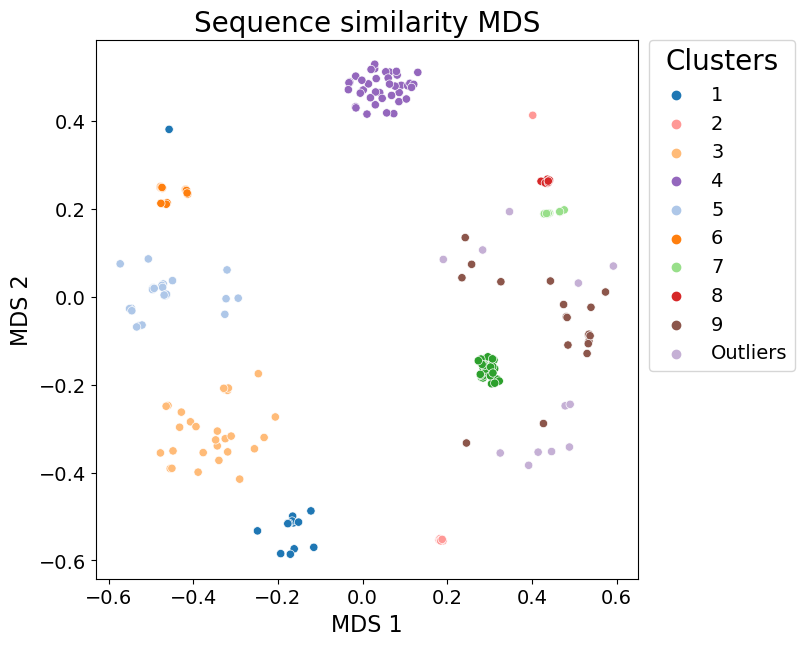

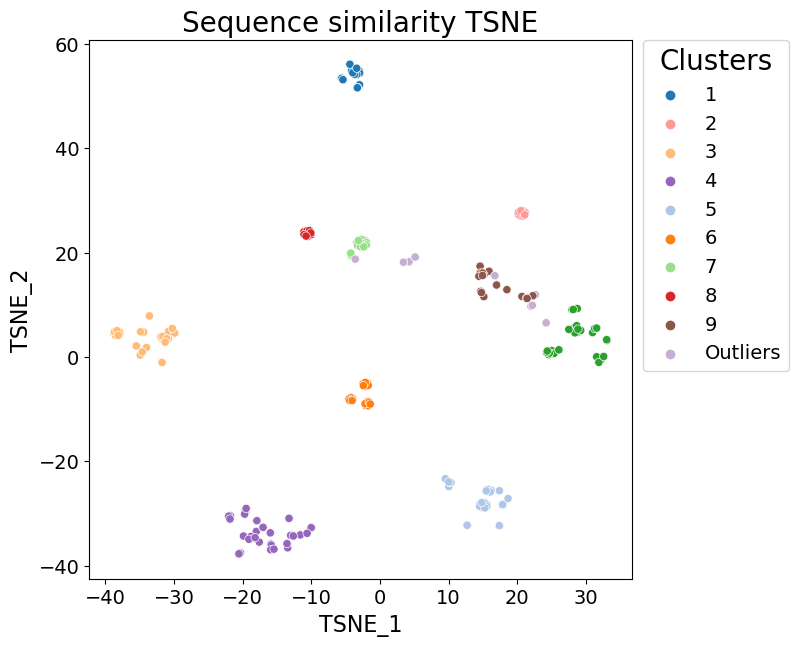

In [3]:
## Identity

seq_dict, np_dist = parse_fix_matrix(DISTANCE_FILE_NAME)


dbscans = HDBSCAN(min_cluster_size = 8, min_samples=3, metric = "precomputed").fit(np_dist.astype(float))

def convert2float(vec):
    return vec.astype(float)

#with open("seq_dist_Global_23_08_03.pkl", "rb") as file_writer: 
#    seq_dict = pickle.load(file_writer)
#print(seq_dict)
dbscans = HDBSCAN(min_cluster_size = 8, min_samples=3, metric = "precomputed").fit(list(map(convert2float, seq_dict["vec"])))
## PCA

pca = MDS(n_components=2, metric=True, dissimilarity = "precomputed")
X_embedded_pca = pca.fit_transform(np_dist.astype(float))



data_pca = {f"MDS 1":[], f"MDS 2":[]}
for x in X_embedded_pca:
    data_pca[f"MDS 1"].append(x[0])
    data_pca[f"MDS 2"].append(x[1])

dict_labels = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10"}
data_pca["label"]=[dict_labels[i] for i in dbscans.labels_]
data_pca["ID"] = seq_dict["id"]
f, ax = plt.subplots(figsize=[7,7])

#sns.set_theme(style="white")

# Load the example mpg dataset

sns.scatterplot(data=data_pca, x=f"MDS 1", y=f"MDS 2", #hue="origin", size="weight",
            alpha=1, palette="tab20", ax=ax, hue="label")
ax.set_title("Sequence similarity MDS")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 7, 3, 8, 1, 2, 5, 6, 10, 9]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("results/img/seq_dist_MDS.png" , bbox_inches="tight")
plt.show()



## T-SNE



X_embedded_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10, metric="precomputed").fit_transform(np_dist.astype(float))

# make_dict

data_t_sne = {"TSNE_1":[], "TSNE_2":[]}
for x in X_embedded_tsne:
    data_t_sne["TSNE_1"].append(x[0])
    data_t_sne["TSNE_2"].append(x[1])

data_t_sne["label"]=[dict_labels[i] for i in dbscans.labels_]
f, ax = plt.subplots(figsize=[7,7])


# Load the example mpg dataset

sns.scatterplot(data=data_t_sne, x="TSNE_1", y="TSNE_2", #hue="origin", size="weight",
            alpha=1, palette="tab20", ax=ax, hue="label")
ax.set_title("Sequence similarity TSNE")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 7, 3, 8, 1, 2, 5, 6, 10, 9]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("results/img/seq_dist_TSNE.png", bbox_inches="tight")
plt.show()



## Define cap domains
Cap domains are defined from reference structure with the specified domains from the three locations. 
The active triad is also defined from a reference structure.

These features are then located in the alignment. Sequences without necessary parts are filtered out from further analysis.

In [5]:
def lable_maker_TANREF(x):
    if x in TAN_REFERENCES:
        return x
    else:
        return ""

def lable_maker_cap(cap1_len, cap2_len, cap3_len):

    string = "Cap at position: "
    ac_1 = 0
    ac_2 = 0

    #string = ""
    if cap1_len > 25:
        string = string + "1"
    elif cap2_len > 35:
        string = string + "2"
    elif cap3_len > 45: 
        string = string + "3"
    else:
        string = "No cap"
    return string

    
seq_dict = pd.DataFrame(seq_dict)   


labels = [dict_key_structure_sequence_70[dict_labels_70[i]] for i in dbscans.labels_]
seq_id_label_map = {_id.split("_")[0]:label for _id, label in zip(seq_dict["id"],labels)}


seq_dict["special_structure"] = seq_dict["id"].apply(lambda x: lable_maker_TANREF(x))
seq_dict["seq_cluster_label"] = seq_dict["id"].apply(lambda x: seq_id_label_map[x])

alignment_dict = {}
for rec in SeqIO.parse(ALIGNMENT_FILE_NAME, "fasta"):
    alignment_dict[rec.id] = str(rec.seq)

# get  positions  in alignment


# Calculate alignment index for caps
cap_start_idxs = [TanBFnp_cap1_sequence_start, TanAAp_cap2_sequence_start, TanBSs_cap3_sequence_start]
cap_end_idxs   = [TanBFnp_cap1_sequence_end, TanAAp_cap2_sequence_end, TanBSs_cap3_sequence_end]
caps = ["cap1", "cap2", "cap3"]
cap_alignment_idx = {"cap1":{"start":0, "end":0}, "cap2":{"start":0, "end":0}, "cap3":{"start":0, "end":0}}
for start, end, _id, cap in zip(cap_start_idxs, cap_end_idxs, reference_structure_ids, caps):
    count_ali = 0
    count_aa = 0
    for aa in alignment_dict[_id]:
            count_ali += 1
            if aa != "-":
                count_aa += 1
            if count_aa == start:
                cap_alignment_idx[cap]["start"] = count_ali
            elif count_aa == end:
                cap_alignment_idx[cap]["end"] = count_ali



# Calculate alignment index for active 3r
alignment_idx_3r = {}
count_ali = 0
count_aa = 0
TanCb2_ali = alignment_dict["TanCb2"]
for aa in TanCb2_ali:
    count_ali += 1
    if aa != "-":
        count_aa += 1

    if count_aa == S_idx:
        assert TanCb2_ali[count_ali-1] == "S"
        alignment_idx_3r["S"] = count_ali - 1 
    elif count_aa == H_idx:
        assert TanCb2_ali[count_ali-1] == "H"
        alignment_idx_3r["H"] = count_ali - 1 
    elif count_aa == D_idx:
        assert TanCb2_ali[count_ali-1] == "D"
        alignment_idx_3r["D"] = count_ali - 1 


    
Active_triad = {}
for row in seq_dict.iterrows():
    _id =  row[1]["id"]
    string = f"{alignment_dict[_id][alignment_idx_3r['S']]}{alignment_dict[_id][alignment_idx_3r['D']]}{alignment_dict[_id][alignment_idx_3r['H']]}"
    Active_triad[row[1]["id"]] = string
seq_dict["Active_triad"] = seq_dict["id"].apply(lambda x: Active_triad[x])
    
seq_dict["class"] = seq_dict["Active_triad"].apply(lambda x: label_maker_TanCb_active(x))
seq_dict["Reason"] =  seq_dict["Active_triad"].apply(lambda x: label_maker_TanCb_active_why_not(x))
 

df_cap = {}
for rec in SeqIO.parse(ALIGNMENT_FILE_NAME, "fasta"):
    cap1_len = len(str(rec.seq[cap_alignment_idx["cap1"]["start"]:cap_alignment_idx["cap1"]["end"]]).replace('-', ''))
    cap2_len = len(str(rec.seq[cap_alignment_idx["cap2"]["start"]:cap_alignment_idx["cap2"]["end"]]).replace('-', ''))
    cap3_len = len(str(rec.seq[cap_alignment_idx["cap3"]["start"]:cap_alignment_idx["cap3"]["end"]]).replace('-', ''))
    df_cap[rec.id] = (cap1_len, cap2_len, cap3_len)



seq_dict["cap1_length"] = seq_dict["id"].apply(lambda x: df_cap[x][0])
seq_dict["cap2_length"] = seq_dict["id"].apply(lambda x: df_cap[x][1])
seq_dict["cap3_length"] = seq_dict["id"].apply(lambda x: df_cap[x][2])
seq_dict["cap_length_label"] = seq_dict.apply(lambda x: lable_maker_cap(x["cap1_length"], x["cap2_length"], x["cap3_length"]), axis=1)

# save active site csv for r hirarchical clustering
seq_dict[["id","Active_triad","class","Reason"]].to_csv("active_site_class.csv")


In [6]:
seq_dict

,id,vec,special_structure,seq_cluster_label,Active_triad,class,Reason,cap1_length,cap2_length,cap3_length,cap_length_label
0,TanAAp,"[0.000000, 0.646154, 0.625641, 0.677138, 0.826...",TanAAp,5,SNH,Amide,Is Tan,15,50,22,Cap at position: 2
1,TanALp,"[0.646154, 0.000000, 0.513423, 0.609075, 0.804...",TanALp,6,SQH,Amide,Is Tan,14,68,21,Cap at position: 2
2,TanASl,"[0.625641, 0.513423, 0.000000, 0.643979, 0.814...",TanASl,4,SQH,Amide,Is Tan,14,50,22,Cap at position: 2
3,TanASg,"[0.677138, 0.609075, 0.643979, 0.000000, 0.778...",TanASg,3,SQH,Amide,Is Tan,10,66,21,Cap at position: 2
4,TanBFnp,"[0.826347, 0.804391, 0.814371, 0.778443, 0.000...",TanBFnp,10,SDH,Acid,Is Tan,37,3,27,Cap at position: 1
...,...,...,...,...,...,...,...,...,...,...,...
222,2917284871,"[0.791489, 0.795745, 0.842553, 0.757447, 0.731...",,1,SDH,Acid,Is Tan,20,14,20,No cap
223,2923823150,"[0.826923, 0.824786, 0.799145, 0.820513, 0.542...",,8,SDH,Acid,Is Tan,33,3,27,Cap at position: 1
224,2925425477,"[0.816631, 0.823028, 0.799574, 0.778252, 0.571...",,7,SDH,Acid,Is Tan,33,3,28,Cap at position: 1
225,2925436013,"[0.818763, 0.808102, 0.797441, 0.780384, 0.569...",,7,SDH,Acid,Is Tan,33,3,28,Cap at position: 1


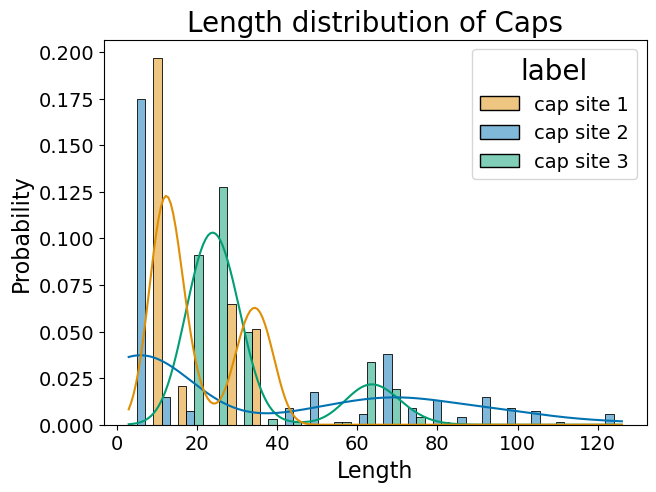

In [7]:
cap_len_dict = {"ids":[],"Length":[],"label":[]}

for row in seq_dict.iterrows():
    _id = row[1]["id"]
    cap1 = row[1]["cap1_length"]
    cap2 = row[1]["cap2_length"]
    cap3 = row[1]["cap3_length"]
    
    cap_len_dict["ids"].append(_id)
    cap_len_dict["Length"].append(cap1)
    cap_len_dict["label"].append("cap site 1")

    cap_len_dict["ids"].append(_id)
    cap_len_dict["Length"].append(cap2)
    cap_len_dict["label"].append("cap site 2")

    cap_len_dict["ids"].append(_id)
    cap_len_dict["Length"].append(cap3)
    cap_len_dict["label"].append("cap site 3")

plt.figure(figsize=[7,5])
# Redifine color palette to conform to heatmap annotations in R script
col = [sns.color_palette("colorblind")[1], sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[2]]

sns.histplot(data=cap_len_dict, x="Length", hue="label", palette = col, multiple = "dodge",  bins = 20, stat = "probability", kde = True)
#sns.violinplot(data=cap_len_dict, x="Length", y="label", bw_adjust = 0.01)
#plt.yscale("log")
plt.title("Length distribution of Caps")
plt.savefig("results/length_of_caps.png")

NameError: name 'plt' is not defined

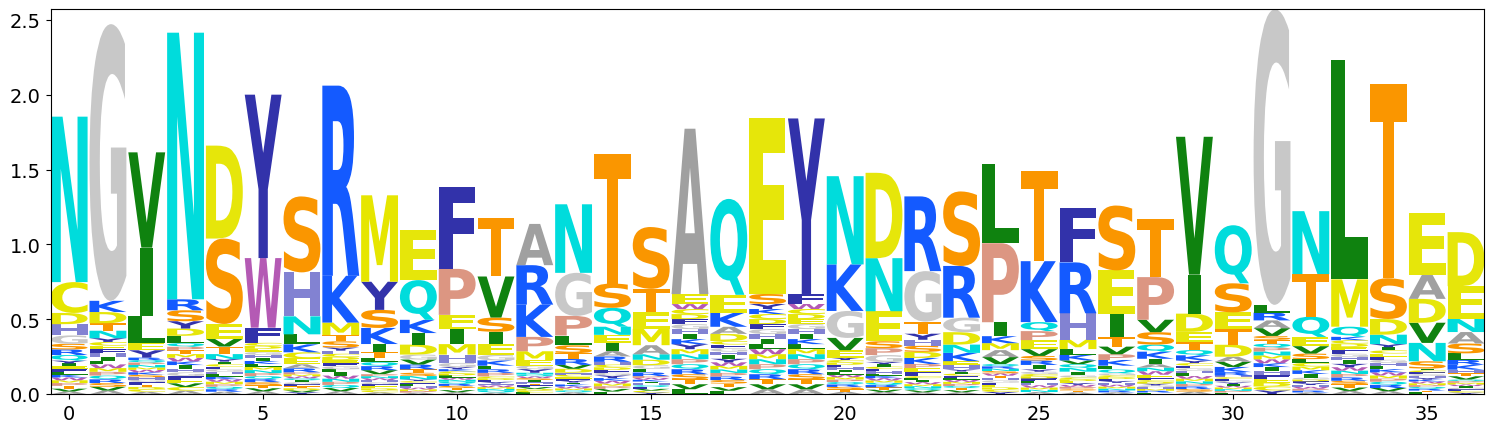

In [8]:
%matplotlib inline
plt.ion()



df_ali = {"cap1":[], "cap2":[], "cap3":[]}

for cap in ["cap1", "cap2", "cap3"]:
    #with open(f"{DIR_ALIGNED_CAP}{cap}.ali", "w"): 
    for rec in alignment_dict.items():
        
        _id = rec[0]
        seq = rec[1]
        
        
        label = seq_dict.loc[seq_dict["id"] == _id]["cap_length_label"].values[0].split()[-1]
        if f"cap{label}" == cap:
            start = cap_alignment_idx[cap]["start"]
            end   = cap_alignment_idx[cap]["end"]
            df_ali[cap].append(seq[start:end])
            #print(_id, label,  start, end, seq[start:end])
                
ww_counts_df = lm.alignment_to_matrix(sequences=df_ali["cap1"], to_type='information', characters_to_ignore='.-X')
plotRegions(ww_counts_df, "cap1", 0, cap_alignment_idx["cap1"]["end"]-cap_alignment_idx["cap1"]["start"])

ww_counts_df = lm.alignment_to_matrix(sequences=df_ali["cap2"], to_type='information', characters_to_ignore='-')
plotRegions(ww_counts_df, "cap2", 0, cap_alignment_idx["cap2"]["end"]-cap_alignment_idx["cap2"]["start"])


ww_counts_df = lm.alignment_to_matrix(sequences=df_ali["cap3"], to_type='information', characters_to_ignore='.-X')
plotRegions(ww_counts_df, "cap3", 0, cap_alignment_idx["cap3"]["end"]-cap_alignment_idx["cap3"]["start"])